# Importing the required modules

In [ ]:
!pip install pyod
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import cohen_kappa_score


# Reading the data

## Train Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/Courses/CS PhD/Courses/AI-for Cybersecurity App./AI Project/Datasets/Training.zip'

Archive:  /content/drive/MyDrive/Courses/CS PhD/Courses/AI-for Cybersecurity App./AI Project/Datasets/Training.zip
  inflating: Training.tsv            


In [55]:
train = pd.read_csv('Training.tsv', sep='\t', index_col=0) # string version of the word vector

In [54]:
train_df = train.copy() # This will contain the numpy arrays of word vector

In [ ]:
train_df.head()

,category,word_vector,label
0,24,"[[-0.507, -0.49518, 0.46885, 0.54524, -0.11552...",2.0
1,13,"[[0.19911, -0.46156, 0.19674, -1.3298, 0.51805...",1.0
2,24,"[[-0.7403, -0.78746, 0.47018, 0.43474, 0.05842...",1.0
3,21,"[[-0.44257, -0.54624, 0.25403, 0.80731, 1.026,...",1.0
4,13,"[[0.19911, -0.46156, 0.19674, -1.3298, 0.51805...",2.0


## Test Data

In [6]:
!unzip '/content/drive/MyDrive/Courses/CS PhD/Courses/AI-for Cybersecurity App./AI Project/Datasets/Testing.zip'

Archive:  /content/drive/MyDrive/Courses/CS PhD/Courses/AI-for Cybersecurity App./AI Project/Datasets/Testing.zip
  inflating: Testing.tsv             


In [107]:
test_df = pd.read_csv('/content/Testing.tsv', sep='\t', index_col=0)

1. Kappa score on test set for each model
-> basic metrics on train and kappa on test

In [ ]:
test_df.head()

,category,word_vector
0,22,"[[0.21287, 0.01892, 0.96733, 1.1927, 0.65862, ..."
1,13,"[[0.19911, -0.46156, 0.19674, -1.3298, 0.51805..."
2,24,"[[-0.7403, -0.78746, 0.47018, 0.43474, 0.05842..."
3,18,"[[-0.40747, -0.23971, -0.13692, -0.26816, -0.1..."
4,5,"[[-0.061445, 0.28243, 0.27775, 0.12486, 0.3929..."


# Data Analysis

In [ ]:
train_df['category'].value_counts()

13    45902
24    24434
6     15346
7      6202
21     5016
1      4978
19     4766
16     3666
18     2894
17     1744
0      1250
20     1246
9      1146
22      920
4       730
23      608
3       608
11      480
8       368
15      306
14      218
10      154
5        34
2        18
12        6
Name: category, dtype: int64

This piece of code depicts a clear balance in our dataset, hence we will now evaluate if there are any null values that might affect this analysis

[2. 1.]
Percentage of attacks in dataset (1s) =  50.0 %
Percentage of attacks in dataset (0s) =  50.0 %




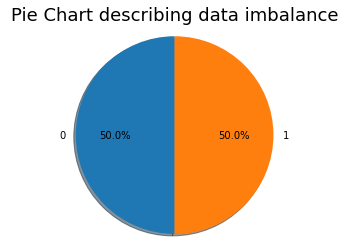

In [ ]:
# train_df['label'].value_counts()
print(train_df['label'].unique())
zero_count = train_df['label'].value_counts()[1.0]
ones_count = train_df['label'].value_counts()[2.0]
print("Percentage of attacks in dataset (1s) = " , ones_count/len(train_df) * 100, "%")
print("Percentage of attacks in dataset (0s) = " , zero_count/len(train_df) * 100, "%")

print('\n')

labels = '0', '1'
sizes = [zero_count/len(train_df) * 100, ones_count/len(train_df) * 100]

fig1, ax1 = plt.subplots()
plt.title('Pie Chart describing data imbalance', fontsize=18)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 

plt.show()

There are no null values, our previous observation holds true

In [ ]:
train_df.isna().sum()

category       0
word_vector    0
label          0
dtype: int64

We observe that the word vectors are arrays Nx100 dimension, hence we will now try to flatten the array by computing the mean

In [ ]:
train_df.iloc[0]['word_vector']

'[[-0.507, -0.49518, 0.46885, 0.54524, -0.11552, 0.2011, -1.2176, -0.55043, -0.23156, -0.73012, 0.076796, -0.0076557, 0.48287, -0.58794, -0.23533, -0.027945, 0.11532, 1.4314, -0.1661, -0.63121, 0.39653, 0.085811, -0.49551, 0.3343, 0.59546, 0.52539, 0.001811, 0.76602, 0.38397, -0.13461, 0.049899, -0.61139, 1.2131, 0.18614, 1.167, 0.35961, 1.3196, -0.82462, 1.6268, -0.49592, 1.0267, -1.3948, 0.056058, -0.61447, 0.19587, 0.97458, -0.037163, -0.54479, 0.081985, 0.048466, 0.13609, -0.23278, -0.17423, -1.54, -1.5503, 0.78742, 0.47568, -0.5873, 0.76837, -0.17776, -0.25306, -0.37216, -0.12001, -0.44639, 0.61284, -1.7839, 0.6673, 0.34053, -0.3449, -1.6066, 0.39333, -0.38133, 0.079142, 0.72345, 1.0916, -1.1843, 0.21262, 0.29126, -0.10723, -1.0812, 0.45819, 0.81771, 0.1528, 0.65375, 0.39089, -0.15801, 0.38404, 0.1913, 0.36868, 0.54634, 0.16972, -0.90728, -0.41876, -0.30595, -0.19465, 0.74824, 0.19289, 0.20424, -0.78606, -0.57961], [-0.32751, -1.2862, 0.65581, 0.34081, 0.12088, 0.22828, 0.24592, -

Our column category is a categorical variable and hence does not require any preprocessing but the column 'word_vector' does

In [ ]:
train_df

,category,word_vector,label
0,24,"[[-0.507, -0.49518, 0.46885, 0.54524, -0.11552...",2.0
1,13,"[[0.19911, -0.46156, 0.19674, -1.3298, 0.51805...",1.0
2,24,"[[-0.7403, -0.78746, 0.47018, 0.43474, 0.05842...",1.0
3,21,"[[-0.44257, -0.54624, 0.25403, 0.80731, 1.026,...",1.0
4,13,"[[0.19911, -0.46156, 0.19674, -1.3298, 0.51805...",2.0
...,...,...,...
123035,24,"[[-0.081545, 0.25175, 0.027983, 0.064531, 0.25...",2.0
123036,7,"[[-0.35721, -0.54399, 0.26479, -0.15312, -0.00...",2.0
123037,19,"[[-1.5145, 0.9682, 0.34735, 1.0024, 0.042789, ...",2.0
123038,13,"[[0.19911, -0.46156, 0.19674, -1.3298, 0.51805...",1.0


In [198]:
train.duplicated().sum()

114881

In [197]:
train[train.duplicated()]['label'].value_counts()

1.0    59844
2.0    55037
Name: label, dtype: int64

Trying to understand the duplicate data. We realise that the duplicates are not biased to one class. Therefore, we will decide by takinng a baseline on both models 

# Data preprocessing

In order to read the string values as integers, we are using eval on each value

In [56]:
train_df['word_vector'] = train_df['word_vector'].apply(lambda x: np.array(eval(x)))

In [ ]:
train_df['word_vector'][0]

We have flattened the array now by replacing the entire array with the mean of the array which makes it look like this

In [57]:
train_df['word_vector'] = train_df['word_vector'].apply(lambda x: np.mean(x, axis=0))

In [ ]:
train_df['word_vector'][0]

In [ ]:
train_df

In [58]:
word_vectors = np.stack(train_df.drop(['label'], axis=1)['word_vector'].to_numpy())

In [ ]:
word_vectors

In [59]:
X = np.hstack([word_vectors, train_df['category'].to_numpy().reshape(-1, 1)])
Y = train_df['label']

In [60]:
train_df = pd.DataFrame(X)
train_df['label'] = Y

In [ ]:
print(X.shape, Y.shape)

In [ ]:
train

In [ ]:
train[~train.duplicated()]['label'].value_counts()

In [ ]:
def tsne_plot(X, Y):
  tsne = TSNE(n_components=2, verbose=1)
  z = tsne.fit_transform(X) 
  TSNE_training = pd.DataFrame()
  TSNE_training["y"] = Y
  TSNE_training["comp-1"] = z[:,0]
  TSNE_training["comp-2"] = z[:,1]

  sns.scatterplot(x="comp-1", y="comp-2", hue=TSNE_training.y.tolist(),
                  data=TSNE_training).set(title="TSNE projection for Training dataset") 

In [ ]:
tsne_plot(X, Y)

In [108]:
test_df['word_vector'] = test_df['word_vector'].apply(lambda x: np.array(eval(x)))

In [109]:
test_df['word_vector'] = test_df['word_vector'].apply(lambda x: np.mean(x, axis=0))

In [110]:
word_vectors_test = np.stack(test_df['word_vector'].to_numpy())

In [111]:
X_test = np.hstack([word_vectors_test, test_df['category'].to_numpy().reshape(-1, 1)])

In [112]:
test_df = pd.DataFrame(X_test)

# Creating the upsampled dataset version

In [61]:
upsampled_train_df = pd.DataFrame(X)
upsampled_train_df['label'] = Y

In [62]:
upsampled_train_df = upsampled_train_df.drop_duplicates()

In [40]:
upsampled_train_df.label.value_counts()

1.0    2
2.0    1
Name: label, dtype: int64

In [63]:
X = upsampled_train_df.drop(['label'], axis=1)
Y = upsampled_train_df['label']

In [64]:
sm = RandomOverSampler(random_state=42)
X_res, y_res = sm.fit_resample(X, Y)

In [ ]:
tsne_plot(X_res, y_res)

In [65]:
upsampled_train_df = pd.DataFrame(X_res)
upsampled_train_df['label'] = y_res

<ipython-input-65-e7d1790fdbda>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  upsampled_train_df['label'] = y_res


In [ ]:
upsampled_train_df

# Defining the baselines

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, recall_score
from imblearn.metrics import geometric_mean_score

seed_value = 42
np.random.seed(12345)

def baseline(xtrain, ytrain, xtest, ytest) :
  accuracy = {}
  f1_score_vals = {}
  recall_vals = {}
  g_mean = {}
  # -------------------- Decision Tree ---------------------------------
  # Decision Trrr  - using an implicitly ensembled model to get baseline
  r_tree = DecisionTreeClassifier(random_state=seed_value)
  r_tree.fit(xtrain,ytrain)
  y_pred_tree = r_tree.predict(xtest)
  accuracy["Decision Tree"] = r_tree.score(xtest,ytest)
  f1_score_vals["Decision Tree"] = f1_score(ytest, y_pred_tree)
  recall_vals["Decision Tree"] = recall_score(ytest, y_pred_tree)
  g_mean['Decision Tree'] = geometric_mean_score(ytest, y_pred_tree)

  # print confusion matrix
  conf_mat = confusion_matrix(ytest,y_pred_tree)
  f, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
  plt.xlabel("Predicted Values")
  plt.ylabel("True Values")
  plt.show()

  # ----------------- LOGISTIC REGRESSION -----------------------------
  log_reg = LogisticRegression(random_state=seed_value)
  log_reg.fit(xtrain,ytrain)
  y_pred_lr = log_reg.predict(xtest)
  accuracy["Logistic Regression"] = log_reg.score(xtest,ytest)
  f1_score_vals["Logistic Regression"] = f1_score(ytest, y_pred_lr)
  recall_vals["Logistic Regression"] = recall_score(ytest, y_pred_lr)
  g_mean['Logistic Regression'] = geometric_mean_score(ytest, y_pred_lr)

  conf_mat = confusion_matrix(ytest,y_pred_lr)
  f, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
  plt.xlabel("Predicted Values")
  plt.ylabel("True Values")
  plt.show()

  # ----------------------------- SVM ---------------------------------
  svm = SVC(kernel='linear', max_iter=100000)
  svm.fit(xtrain,ytrain)
  y_pred_svm = svm.predict(xtest)
  accuracy["svm"] = svm.score(xtest,ytest)
  f1_score_vals["svm"] = f1_score(ytest, y_pred_svm)
  recall_vals["svm"] = recall_score(ytest, y_pred_svm)
  g_mean['svm'] = geometric_mean_score(ytest, y_pred_svm)

  
  conf_mat = confusion_matrix(ytest,y_pred_svm)
  f, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
  plt.xlabel("Predicted Values")
  plt.ylabel("True Values")
  plt.show()

  return accuracy, f1_score_vals, recall_vals, g_mean

In [ ]:
def show_skewness (data):
  for i in data.columns:
    data[i].plot(kind='kde')
    plt.title(f"Density plot of {i} with skewness "+ str(data[i].skew(axis=0)))
    plt.show()
    plt.xlabel(i)
    print('\n')

In [ ]:
def requiring_scaling (data):
  for i in data.columns:
    if data[i].max() - data[i].min() > 3:
      print(i)
      data[i].plot(kind='kde')
      plt.title(f"Density plot of {i} with skewness "+ str(data[i].skew(axis=0)))
      plt.show()
      plt.xlabel(i)
    print('\n')

In [152]:
train_df_X = train_df.drop(['label'], axis=1)
train_df_y = train_df['label']

In [153]:
upsampled_train_df_X = upsampled_train_df.drop(['label'], axis=1)
upsampled_train_df_y = upsampled_train_df['label']

In [154]:
X_train, X_dev, y_train, y_dev = train_test_split(
    train_df_X, train_df_y, test_size=0.33, random_state=42)

In [155]:
from sklearn.preprocessing import StandardScaler    
st_x= StandardScaler()    
X_train= st_x.fit_transform(X_train)    
X_dev= st_x.transform(X_dev)

In [156]:
upsampled_X_train, upsampled_X_dev, upsampled_y_train, upsampled_y_dev = train_test_split(
    upsampled_train_df_X, upsampled_train_df_y, test_size=0.33, random_state=42)

In [157]:
from sklearn.preprocessing import StandardScaler    
st_x= StandardScaler()    
upsampled_X_train= st_x.fit_transform(upsampled_X_train)    
upsampled_X_dev= st_x.transform(upsampled_X_dev)

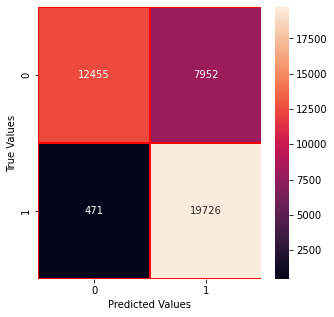

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


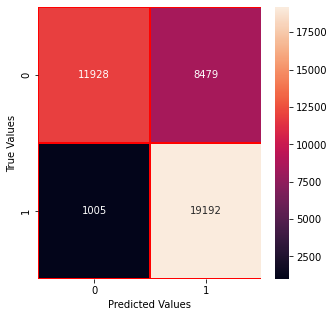

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


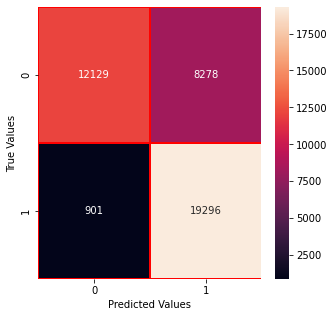

In [158]:
accuracy, f1_score_vals, recall_vals, g_mean = baseline(X_train, y_train, X_dev, y_dev)

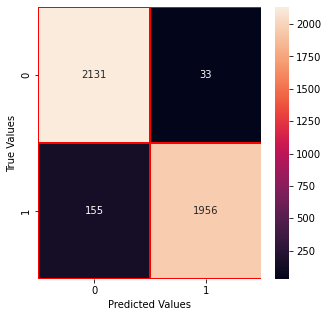

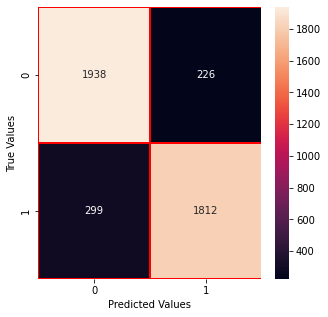

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


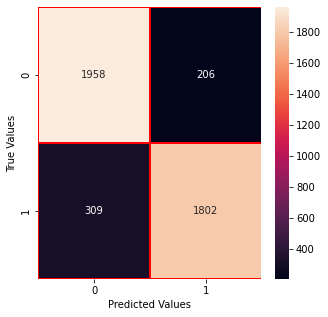

In [159]:
upsampled_accuracy, upsampled_f1_score_vals, upsampled_recall_vals, upsampled_g_mean = baseline(upsampled_X_train, upsampled_y_train, upsampled_X_dev, upsampled_y_dev)

In [160]:
accuracy, f1_score_vals, recall_vals, g_mean

({'Decision Tree': 0.7925573835090138,
  'Logistic Regression': 0.7664269530095557,
  'svm': 0.7739385282238204},
 {'Decision Tree': 0.7473074730747308,
  'Logistic Regression': 0.7155368926214757,
  'svm': 0.7254837455513354},
 {'Decision Tree': 0.6103297887979615,
  'Logistic Regression': 0.5845053168030577,
  'svm': 0.594354878228059},
 {'Decision Tree': 0.7720730004468119,
  'Logistic Regression': 0.7452653292326799,
  'svm': 0.7535518289928657})

In [161]:
upsampled_accuracy, upsampled_f1_score_vals, upsampled_recall_vals, upsampled_g_mean

({'Decision Tree': 0.9560233918128654,
  'Logistic Regression': 0.8771929824561403,
  'svm': 0.87953216374269},
 {'Decision Tree': 0.957752808988764,
  'Logistic Regression': 0.8807089297886845,
  'svm': 0.8837734145791019},
 {'Decision Tree': 0.9847504621072088,
  'Logistic Regression': 0.8955637707948244,
  'svm': 0.9048059149722736},
 {'Decision Tree': 0.955219996158955,
  'Logistic Regression': 0.8767650675878956,
  'svm': 0.8788423813221435})

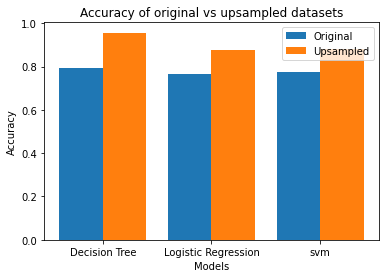

In [162]:
import numpy as np
import matplotlib.pyplot as plt

X = list(accuracy.keys())
original_X = accuracy.values()
upsampled_X = upsampled_accuracy.values()

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, original_X, 0.4, label = 'Original')
plt.bar(X_axis + 0.2, upsampled_X, 0.4, label = 'Upsampled')

plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy of original vs upsampled datasets")
plt.legend()
plt.show()


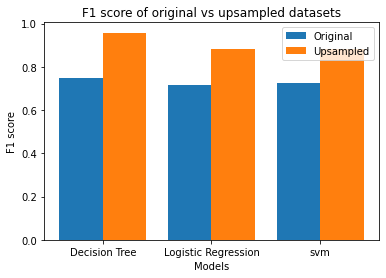

In [163]:
import numpy as np
import matplotlib.pyplot as plt

X = list(f1_score_vals.keys())
original_X = f1_score_vals.values()
upsampled_X = upsampled_f1_score_vals.values()

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, original_X, 0.4, label = 'Original')
plt.bar(X_axis + 0.2, upsampled_X, 0.4, label = 'Upsampled')

plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("F1 score")
plt.title("F1 score of original vs upsampled datasets")
plt.legend()
plt.show()


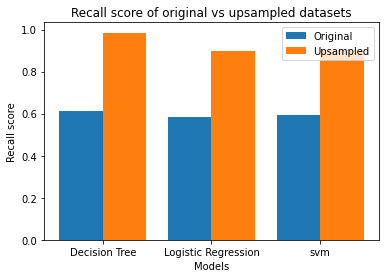

In [164]:
import numpy as np
import matplotlib.pyplot as plt

X = list(recall_vals.keys())
original_X = recall_vals.values()
upsampled_X = upsampled_recall_vals.values()

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, original_X, 0.4, label = 'Original')
plt.bar(X_axis + 0.2, upsampled_X, 0.4, label = 'Upsampled')

plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("Recall score")
plt.title("Recall score of original vs upsampled datasets")
plt.legend()
plt.show()


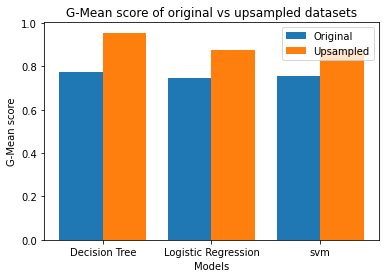

In [165]:
import numpy as np
import matplotlib.pyplot as plt

X = list(g_mean.keys())
original_X = g_mean.values()
upsampled_X = upsampled_g_mean.values()

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, original_X, 0.4, label = 'Original')
plt.bar(X_axis + 0.2, upsampled_X, 0.4, label = 'Upsampled')

plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("G-Mean score")
plt.title("G-Mean score of original vs upsampled datasets")
plt.legend()
plt.show()


In [166]:
u_X_train = upsampled_X_train
u_y_train = upsampled_y_train
u_X_dev = upsampled_X_dev
u_y_dev = upsampled_y_dev

## Dimensionality reduction

###  Using PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
# from sklearn.preprocessing import train_test_split
acc_dict_pca={}
for n_components in range(2,50,10):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(upsampled_train_df_X)
    X_test_pca = pca.fit_transform(upsampled_X_dev)
    DST_PCA_model = DecisionTreeClassifier()
    DST_PCA_model.fit(X_train_pca,upsampled_train_df_y)
    y_predicted_pca = DST_PCA_model.predict(X_test_pca)
    acc_pca = f1_score(upsampled_y_dev,y_predicted_pca)
    acc_dict_pca[n_components]=acc_pca*100

In [ ]:
plt.plot(*zip(*sorted(acc_dict_pca.items())))
Title = "PCA Method to reduce feature dimension"
plt.title(Title, fontsize=16)
plt.xlabel("Number of Components")
plt.ylabel("Accuracy (%)")

In [ ]:
print('for n_components of PCA =',max(acc_dict_pca,key=acc_dict_pca.get), 'we get the maximum accuracy with our baseline model')

### Using Autoencoder

In [100]:
from sklearn.neural_network import MLPRegressor
import numpy as np
def encoder(encoder_weights, encoder_biases, data):
    res_ae = data
    for index, (w, b) in enumerate(zip(encoder_weights, encoder_biases)):
        if index+1 == len(encoder_weights):
            res_ae = res_ae@w+b 
        else:
            res_ae = np.maximum(0, res_ae@w+b)
    return res_ae

In [101]:
from sklearn.neural_network import MLPRegressor
import numpy as np
acc_dict_ae={}
for iteration in range(2,50,10):
    autoencoder = MLPRegressor(alpha=1e-15, 
                            hidden_layer_sizes=(50, 100, 50, iteration, 50, 100, 50), 
                            random_state=1, max_iter=20000)

    autoencoder.fit(u_X_train, u_X_train)

    W = autoencoder.coefs_
    biases = autoencoder.intercepts_
    encoder_weights = W[0:4]
    encoder_biases = biases[0:4]
    res_ae_train = encoder(encoder_weights, encoder_biases, u_X_train)
    res_ae_test = encoder(encoder_weights, encoder_biases, u_X_dev)
    DST_AE_Model = DecisionTreeClassifier()
    DST_AE_Model.fit(res_ae_train,u_y_train)
    y_predicted_ae = DST_AE_Model.predict(res_ae_test)
    print(f1_score(u_y_dev,y_predicted_ae),'for',iteration,'features')
    acc_ae = f1_score(u_y_dev,y_predicted_ae)*100
    acc_dict_ae[iteration]=acc_ae


0.9418012834697942 for 2 features


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.9464046449307726 for 12 features


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.9433962264150944 for 22 features


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.9472277889111557 for 32 features


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.9497879937513949 for 42 features


In [ ]:
plt.plot(*zip(*sorted(acc_dict_ae.items())))
Title = "AE Method to reduce feature dimension"
plt.title(Title, fontsize=16)
plt.xlabel("Number of Components")
plt.ylabel("Accuracy (%)")

In [ ]:
print('for minimum hidden layer of Autoencoder =',max(acc_dict_ae,key=acc_dict_ae.get), 'we get the maximum accuracy with our baseline model')

In [ ]:
plt.plot(*zip(*sorted(acc_dict_pca.items())),label='PCA accuracy')
plt.plot(*zip(*sorted(acc_dict_ae.items())),label='AE accuracy')

plt.title('Accuracy of baseline vs PCA vs Autoencoder', fontsize=16)
plt.legend()
plt.xlabel("Number of Components", )
plt.ylabel("Accuracy (%)", )

the best accuracy we got from dimentionality reduction was from Autoencoder with 9 features   
else the best accuracy as fas was provided by baseline DST

Using 12 best features to get the transformed dataset as justified above:

In [102]:
autoencoder = MLPRegressor(alpha=1e-15, 
                        hidden_layer_sizes=(50, 100, 50, 12, 50, 100, 50), 
                        random_state=1, max_iter=20000)

autoencoder.fit(u_X_train, u_X_train)

W = autoencoder.coefs_
biases = autoencoder.intercepts_
encoder_weights = W[0:4]
encoder_biases = biases[0:4]
res_ae_train = encoder(encoder_weights, encoder_biases, u_X_train)
res_ae_test = encoder(encoder_weights, encoder_biases, u_X_dev)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8679 samples in 0.031s...
[t-SNE] Computed neighbors for 8679 samples in 1.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8679
[t-SNE] Computed conditional probabilities for sample 2000 / 8679
[t-SNE] Computed conditional probabilities for sample 3000 / 8679
[t-SNE] Computed conditional probabilities for sample 4000 / 8679
[t-SNE] Computed conditional probabilities for sample 5000 / 8679
[t-SNE] Computed conditional probabilities for sample 6000 / 8679
[t-SNE] Computed conditional probabilities for sample 7000 / 8679
[t-SNE] Computed conditional probabilities for sample 8000 / 8679
[t-SNE] Computed conditional probabilities for sample 8679 / 8679
[t-SNE] Mean sigma: 0.972613
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.703636
[t-SNE] KL divergence after 1000 iterations: 0.790855


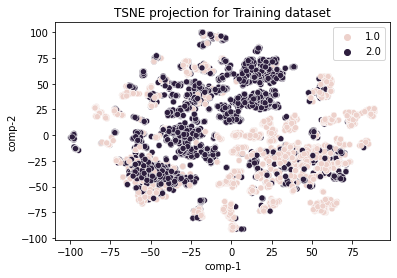

In [ ]:
tsne_plot(res_ae_train, u_y_train)

# Ensemble Model

In [191]:
dst = DecisionTreeClassifier(random_state=seed_value)
lr = LogisticRegression(random_state=seed_value)
svm = SVC(kernel='linear', max_iter=1000000, probability=True)

ensemble = VotingClassifier(estimators=[
        ('dst', dst), ('lr', lr), ('svm', svm)], voting='soft', weights=[3,2,1])

ensemble = ensemble.fit(res_ae_train, u_y_train)

y_pred_ens = ensemble.predict(res_ae_test)


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


f1 score: 0.9412553048916685
Recall score: 0.9736598890942699
Accuracy score: 0.9384795321637427
G Mean score: 0.9373612864312962


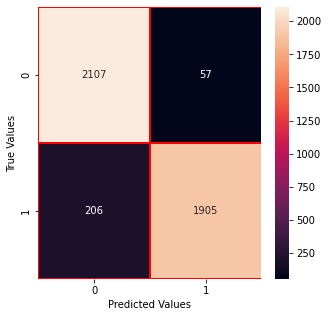

In [192]:
print(f'f1 score: {f1_score(u_y_dev, y_pred_ens)}')
print(f'Recall score: {recall_score(u_y_dev, y_pred_ens)}')
print(f'Accuracy score: {accuracy_score(u_y_dev, y_pred_ens)}')
print(f'G Mean score: {geometric_mean_score(u_y_dev, y_pred_ens)}')

conf_mat = confusion_matrix(u_y_dev, y_pred_ens)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

# Calculating Kappa score on test set

In [184]:
dst = DecisionTreeClassifier(random_state=seed_value)
lr = LogisticRegression(random_state=seed_value)
svm = SVC(kernel='linear', max_iter=100000, probability=True)
ensemble = VotingClassifier(estimators=[
        ('dst', dst), ('lr', lr), ('svm', svm)], voting='soft', weights=[3,2,1])

In [185]:
st_x= StandardScaler()    
upsampled_train_df_X= st_x.fit_transform(upsampled_train_df_X)    
scaled_test_df = st_x.transform(test_df)

In [186]:
res_ae_train_full = encoder(encoder_weights, encoder_biases, upsampled_train_df_X)
res_ae_test_full = encoder(encoder_weights, encoder_biases, scaled_test_df)

In [187]:
svm.fit(res_ae_train_full, upsampled_train_df_y)
lr.fit(res_ae_train_full, upsampled_train_df_y)
dst.fit(res_ae_train_full, upsampled_train_df_y)
ensemble = ensemble.fit(res_ae_train_full, upsampled_train_df_y)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [188]:
test_pred_svm = svm.predict(res_ae_test_full)
test_pred_lr = lr.predict(res_ae_test_full)
test_pred_dst = dst.predict(res_ae_test_full)
test_pred_ens = ensemble.predict(res_ae_test_full)

In [189]:
kappa_scores = {}
kappa_scores['dst_ensemble'] = cohen_kappa_score(test_pred_ens, test_pred_dst)
kappa_scores['lr_ensemble'] = cohen_kappa_score(test_pred_ens, test_pred_lr)
kappa_scores['svm_ensemble'] = cohen_kappa_score(test_pred_ens, test_pred_svm)


In [190]:
kappa_scores

{'dst_ensemble': 0.9990121790716903,
 'lr_ensemble': 0.7686426396119075,
 'svm_ensemble': -0.06600382079747957}

# Cross-validation of models

In [ ]:
dst = DecisionTreeClassifier(random_state=seed_value)
lr = LogisticRegression(random_state=seed_value)
svm = SVC(kernel='linear', max_iter=100000, probability=True)
ensemble = VotingClassifier(estimators=[
        ('dst', dst), ('lr', lr), ('svm', svm)], voting='soft', weights=[3,2,1])

In [175]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

scorings = {'f1': make_scorer(f1_score), 'accuracy': make_scorer(accuracy_score), 
            'recall': make_scorer(recall_score), 'g_mean': make_scorer(geometric_mean_score)}

results = {}
results['dst'] = cross_validate(dst, res_ae_train, u_y_train, cv=5, scoring=scorings)
results['lr'] = cross_validate(lr, res_ae_train, u_y_train, cv=5, scoring=scorings)
results['svm'] = cross_validate(svm, res_ae_train, u_y_train, cv=5, scoring=scorings)
results['ens'] = cross_validate(ensemble, res_ae_train, u_y_train, cv=5, scoring=scorings)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Con

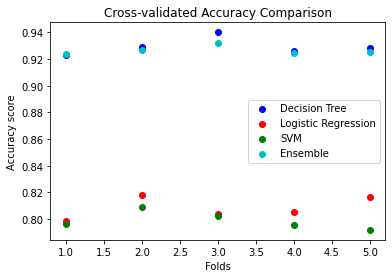

In [176]:
x = range(1, 6)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, results['dst']['test_accuracy'], c='b', label='Decision Tree')
ax1.scatter(x, results['lr']['test_accuracy'], c='r', label='Logistic Regression')
ax1.scatter(x, results['svm']['test_accuracy'], c='g', label='SVM')
ax1.scatter(x, results['ens']['test_accuracy'], c='c', label='Ensemble')
ax.legend('Accuracy')
ax.grid(True)
plt.xlabel("Folds")
plt.ylabel("Accuracy score")
plt.title("Cross-validated Accuracy Comparison")
plt.legend()

plt.show()

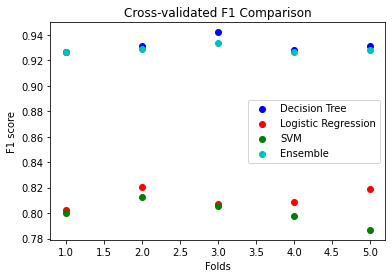

In [177]:
x = range(1, 6)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, results['dst']['test_f1'], c='b', label='Decision Tree')
ax1.scatter(x, results['lr']['test_f1'], c='r', label='Logistic Regression')
ax1.scatter(x, results['svm']['test_f1'], c='g', label='SVM')
ax1.scatter(x, results['ens']['test_f1'], c='c', label='Ensemble')
ax.grid(True)
plt.xlabel("Folds")
plt.ylabel("F1 score")
plt.title("Cross-validated F1 Comparison")
plt.legend()

plt.show()

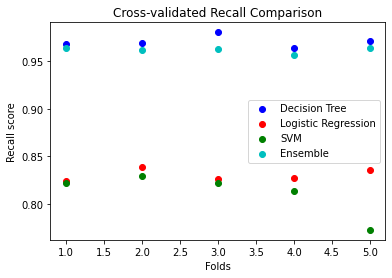

In [178]:
x = range(1, 6)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, results['dst']['test_recall'], c='b', label='Decision Tree')
ax1.scatter(x, results['lr']['test_recall'], c='r', label='Logistic Regression')
ax1.scatter(x, results['svm']['test_recall'], c='g', label='SVM')
ax1.scatter(x, results['ens']['test_recall'], c='c', label='Ensemble')
ax.grid(True)
plt.xlabel("Folds")
plt.ylabel("Recall score")
plt.title("Cross-validated Recall Comparison")
plt.legend()

plt.show()

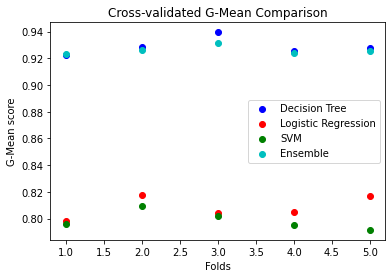

In [179]:
x = range(1, 6)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, results['dst']['test_g_mean'], c='b', label='Decision Tree')
ax1.scatter(x, results['lr']['test_g_mean'], c='r', label='Logistic Regression')
ax1.scatter(x, results['svm']['test_g_mean'], c='g', label='SVM')
ax1.scatter(x, results['ens']['test_g_mean'], c='c', label='Ensemble')
ax.grid(True)
plt.xlabel("Folds")
plt.ylabel("G-Mean score")
plt.title("Cross-validated G-Mean Comparison")
plt.legend()

plt.show()

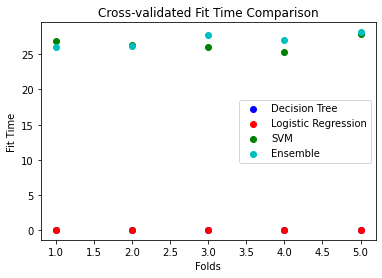

In [180]:
x = range(1, 6)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, results['dst']['fit_time'], c='b', label='Decision Tree')
ax1.scatter(x, results['lr']['fit_time'], c='r', label='Logistic Regression')
ax1.scatter(x, results['svm']['fit_time'], c='g', label='SVM')
ax1.scatter(x, results['ens']['fit_time'], c='c', label='Ensemble')
ax.grid(True)
plt.xlabel("Folds")
plt.ylabel("Fit Time")
plt.title("Cross-validated Fit Time Comparison")
plt.legend()

plt.show()

# Our previous (Depricated) work

## Feature Selection

Now we have split the words vector mean into 100 different columns, our next objective will be to evaluate the features and find the correlation

In [ ]:
xdf = pd.DataFrame(X)

In [ ]:
ydf=pd.DataFrame(Y) 

In [ ]:
new_x=pd.concat([xdf,ydf],axis=1)

In [ ]:
new_x

In [ ]:
xdf_null = new_x.drop_duplicates()
xdf_null

In [ ]:
y = xdf_null["label"]
y

In [ ]:
xdf_null.drop(columns = ['label'], inplace=True)
xdf_null

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

#Selecting best features based on mutual Info Reg.
selector = SelectKBest(mutual_info_regression, k =70)
selector.fit(xdf_null, y)
xdf_null.columns[selector.get_support()]

In [ ]:
#RFE for feature selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

#Selecting the best features based on Logistic Reg.
rfe_selector = RFE(estimator=LogisticRegression(),n_features_to_select = 70, step = 70)
rfe_selector.fit(xdf_null, y)
xdf_null.columns[rfe_selector.get_support()]

In [ ]:
selcetk = [ 0,   1,   2,   3,   4,   6,   8,   9,  10,  11,  12,  13,  14,  16,
        17,  18,  19,  20,  21,  22,  24,  25,  26,  27,  28,  29,  32,  33,
        34,  35,  37,  38,  40,  41,  44,  45,  46,  49,  50,  52,  54,  55,
        57,  58,  59,  62,  63,  64,  66,  67,  69,  71,  72,  74,  77,  78,
        79,  80,  82,  83,  84,  87,  90,  91,  92,  93,  94,  96,  98, 100]
rfe = [0,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 17, 21, 23, 24,
       26, 28, 29, 31, 32, 33, 35, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51,
       52, 54, 55, 56, 57, 59, 60, 61, 62, 64, 65, 67, 68, 69, 71, 72, 73, 75,
       76, 78, 79, 80, 82, 83, 85, 86, 87, 90, 92, 93, 95, 96, 97, 98]
common_features = np.intersect1d(selcetk,rfe)
print(common_features)


In [ ]:
print(len(common_features))

In [ ]:
x_f = xdf_null.iloc[:,[0,  2,  3,  4,  6,  9, 10, 11, 12, 13, 14 ,17, 21, 24, 26, 28, 29, 32, 33, 35, 40, 41, 45, 46,
 49, 50, 52, 54, 55, 57, 59, 62, 64, 67, 69, 71, 72, 78, 79, 80, 82, 83, 87, 90, 92, 93, 96, 98,100]]
x_f

In [ ]:
cor = x_f.corrwith(y).sort_values(ascending=False)

In [ ]:
type(cor)

In [ ]:
cor.plot()

In [ ]:
x_f.describe()

We have a large number of duplicates that make bias, Upon printing the duplicate values; we see that we have 93% duplicates 

In [ ]:
x_f.duplicated().sum()/len(x_f) * 100

We drop the duplicates and further proceed to feature extraction

In [ ]:
#xdf_null = xdf.drop_duplicates()

In [ ]:
#xdf_null

In [ ]:
for i in x_f.columns:
  xdf_null[i].plot(kind='kde')
  plt.title("Density plot of "+ str(i) +" with skewness "+ str(x_f[i].skew(axis=0)))
  plt.show()
  plt.xlabel(i)
  print('\n')

In [ ]:
x_f.var()

In [ ]:
x_f

In [ ]:
new_x=pd.concat([x_f,y],axis=1)

In [ ]:
new_x

In [ ]:
import seaborn as sns
cormat = new_x.corr() 
plt.figure(figsize=(15,15)) 
sns.heatmap(cormat, square=True, annot=True, linewidths=0.5) 
plt.title("Correlation matrix among variables") 
plt.show()

## Defining the baseline

Previously:

In [ ]:
({'Random Forest': 0.9590643274853801,
  'Logistic Regression': 0.8853801169590644,
  'XGBOOST': 0.9340350877192982},
 {'Random Forest': 0.9597978405697221,
  'Logistic Regression': 0.8889392565729828,
  'XGBOOST': 0.9361702127659575})

*  We should decide which baseline are we going to use. We can either use the rgf, random forest or the naive bayes classifier
*  define metrics
*  use models that are ensemble in the core
*  combine different models using votigclassifiers
*  the metric plots
*  Comparisons

Use autoencoders of different shapes for feature engineering 
correlation
cross validation

In [ ]:
!pip install rgf_python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 757 kB 29.2 MB/s 


##Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
y_pred=clf.predict(X_dev)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_dev, y_pred))

Accuracy: 0.8153102935711631


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
confusion_matrix(y_dev, y_pred)

array([[ 105,  474],
       [  23, 2089]])

In [ ]:
print(classification_report(y_dev, y_pred))

              precision    recall  f1-score   support

         1.0       0.82      0.18      0.30       579
         2.0       0.82      0.99      0.89      2112

    accuracy                           0.82      2691
   macro avg       0.82      0.59      0.60      2691
weighted avg       0.82      0.82      0.77      2691



##iForest

In [ ]:
from pyod.models.iforest import IForest

In [ ]:
clf = IForest()
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/pyod/models/base.py:411: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")


IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [ ]:
y_pred1=clf.predict(X_dev)
print("Accuracy:",metrics.accuracy_score(y_dev, y_pred1))

Accuracy: 0.016350798959494612


In [ ]:
print(classification_report(y_dev, y_pred))

              precision    recall  f1-score   support

         1.0       0.82      0.18      0.30       579
         2.0       0.82      0.99      0.89      2112

    accuracy                           0.82      2691
   macro avg       0.82      0.59      0.60      2691
weighted avg       0.82      0.82      0.77      2691



Geometric mean, f1 score

##RGF

In [ ]:
from rgf.sklearn import RGFClassifier

In [ ]:
rgf = RGFClassifier(max_leaf=400,
                    algorithm="RGF_Sib",
                    test_interval=100,
                    verbose=True)

In [ ]:
rgf.fit(X_train, y_train)

n_jobs = -1, but RGFClassifier uses one CPU because classes_ is 2
"train": 
   algorithm=RGF_Sib
   train_x_fn=/tmp/rgf/f1e3d4b7-7ac4-4fcd-993e-a1ed29ea84491.train.data.x
   train_y_fn=/tmp/rgf/f1e3d4b7-7ac4-4fcd-993e-a1ed29ea84491.train.data.y
   Log:ON
   model_fn_prefix=/tmp/rgf/f1e3d4b7-7ac4-4fcd-993e-a1ed29ea84491.model
--------------------
Sun Nov 27 11:13:26 2022: Reading training data ... 
Sun Nov 27 11:13:26 2022: Start ... #train=5461
--------------------
Forest-level: 
   loss=Log
   max_leaf_forest=400
   max_tree=200
   opt_interval=100
   test_interval=100
   num_tree_search=1
   Verbose:ON
   memory_policy=Generous
Turning on Force_to_refresh_all
-------------
Training data: 49x5461, nonzero_ratio=0.9999; managed as dense data.
-------------
Optimization: 
   loss=Log
   num_iteration_opt=5
   reg_L2=0.1
   opt_stepsize=0.5
   max_delta=1
Tree-level: min_pop=10
Node split: reg_L2=0.1
--------------------
Sun Nov 27 11:13:27 2022: Calling optimizer with 23 trees and 100 l

RGFClassifier(algorithm='RGF_Sib', max_leaf=400, verbose=True)

In [ ]:
y_pred2=rgf.predict(X_dev)
print("Accuracy:",metrics.accuracy_score(y_dev, y_pred2))

"predict": 
   model_fn=/tmp/rgf/f1e3d4b7-7ac4-4fcd-993e-a1ed29ea84491.model-04
   test_x_fn=/tmp/rgf/f1e3d4b7-7ac4-4fcd-993e-a1ed29ea84491.test.data.x
   prediction_fn=/tmp/rgf/f1e3d4b7-7ac4-4fcd-993e-a1ed29ea84491.predictions.txt
   Log:ON
--------------------
Sun Nov 27 11:13:31 2022: Reading test data ... 
Sun Nov 27 11:13:31 2022: Predicting ... 
elapsed: 0.008834
/tmp/rgf/f1e3d4b7-7ac4-4fcd-993e-a1ed29ea84491.predictions.txt: /tmp/rgf/f1e3d4b7-7ac4-4fcd-993e-a1ed29ea84491.model-04,#leaf=400,#tree=62
Sun Nov 27 11:13:31 2022: Done ... 

Accuracy: 0.9327387588257153


In [ ]:
print(classification_report(y_dev, y_pred2))

              precision    recall  f1-score   support

         1.0       0.86      0.82      0.84       579
         2.0       0.95      0.96      0.96      2112

    accuracy                           0.93      2691
   macro avg       0.91      0.89      0.90      2691
weighted avg       0.93      0.93      0.93      2691



##Scaling the data

In [ ]:
from sklearn.preprocessing import StandardScaler    
st_x= StandardScaler()    
x_train= st_x.fit_transform(X_train)    
x_test= st_x.transform(X_dev)

##SVM

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"  
classifier = SVC(kernel='linear', random_state=0)  
classifier.fit(x_train, y_train) 

SVC(kernel='linear', random_state=0)

In [ ]:
y_pred= classifier.predict(x_test)  

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_dev, y_pred))

Accuracy: 0.8851727982162765


In [ ]:
print(classification_report(y_dev, y_pred))

              precision    recall  f1-score   support

         1.0       0.73      0.74      0.73       579
         2.0       0.93      0.93      0.93      2112

    accuracy                           0.89      2691
   macro avg       0.83      0.83      0.83      2691
weighted avg       0.89      0.89      0.89      2691

